In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np

#1- Download Dataset(2 p)
download dataset from this link and extract it:
http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz

In [ ]:
# -----------------------------------------------------
# Downaload dataset from above link with !wget
# Extract it with 
# -----------------------------------------------------
############### Complete this part ##############(2 points)

!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
!tar -xvf 'maps.tar.gz'

#2- Dataset Class(3 p)

In [3]:
class Maps_Dataset(Dataset):
    def __init__(self, ImagesDirectory):
        self.ImagesDirectory = ImagesDirectory
        self.files = os.listdir(self.ImagesDirectory)
        self.transforms = transforms.Compose([  transforms.Resize((256, 256), Image.BICUBIC),
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        # reading one image from dataset
        img_name = self.files[index]
        img_path = os.path.join(self.ImagesDirectory, img_name)
        img = Image.open(img_path)
        # -----------------------------------------------------
        # split image into two part IMAGE and MAP (see one sample of dataset)
        # apply self.transforms to IMAGE and MAP to Normalize and Resize the images
        # -----------------------------------------------------
        ############### Complete this part ############### (3 points)
        IMAGE = img.crop((0,0,img.size[0]/2,img.size[1]))
        MAP = img.crop((img.size[0]/2, 0, img.size[0], img.size[1]))
        IMAGE = self.transforms(IMAGE)
        MAP = self.transforms(MAP)



        return {"IMAGE": IMAGE , "MAP": MAP}

#3-Create Generator with the help of the Block module and test it(32 p)

In [4]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()

        # Select appropriate convolutional or transpose convolutional layer
        if down:
            self.conv = nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
        else:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False)
        
        # Initialize batch normalization and activation layers
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2)

        # Flag for using dropout
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Apply convolutional layer
        x = self.conv(x)

        # Apply batch normalization and activation
        x = self.bn(x)
        x = self.act(x)

        # Apply dropout if specified
        if self.use_dropout:
            x = self.dropout(x)

        return x

class Generator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()


        # -----------------------------------------------------
        # based on aritcle appendix define Encoder( page 16)
        # C64-C128-C256-C512-C512-C512-C512-C512
        # -----------------------------------------------------
        ############### Complete this part ############### (10 points)
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, 64 , 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        ) # C3 => C64
        
        self.down1 = Block(64, 128)
        self.down2 = Block(128, 256)
        self.down3 = Block(256, 512)
        self.down4 = Block(512, 512)
        self.down5 = Block(512, 512)
        self.down6 = Block(512, 512)


        self.bottleneck = nn.Sequential(
            nn.Conv2d(512 , 512 , 4, 2, 1), nn.ReLU()
        )
        # -----------------------------------------------------
        # based on aritcle appendix define Decoder ( page 16)
        # CD512-CD512-CD512-C512-C256-C128-C64
        # -----------------------------------------------------
        ############### Complete this part ############### (10 points)

        self.up1 = Block(512, 512, down=False)
        self.up2 = Block(512*2, 512, down=False)
        self.up3 = Block(512*2, 512, down=False)
        self.up4 = Block(512*2, 512, down=False)
        self.up5 = Block(512*2, 256, down=False)
        self.up6 = Block(512, 128, down=False)
        self.up7 = Block(256, 64, down=False)

        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(128, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # -----------------------------------------------------
        # create network like U-Net
        # -----------------------------------------------------
        ############### Complete this part ############### (10 points)
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)

        btlnk = self.bottleneck(d7)

        u1 = self.up1(btlnk)
        u2 = self.up2(torch.cat([u1, d7], 1))
        u3 = self.up3(torch.cat([u2, d6], 1))
        u4 = self.up4(torch.cat([u3, d5], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))
        Out = self.final_up(torch.cat([u7, d1], 1))

        return Out

In [5]:
def test():
    # -----------------------------------------------------
    #  test generator : output should be (B,C,256,256)
    # -----------------------------------------------------
    ############### Complete this part ############### (2 points)
    # test the model
    x = torch.randn((1, 3, 256, 256))
    model = Generator(in_channels=3)
    preds = model(x)
    print(preds.shape)

test()

torch.Size([1, 3, 256, 256])


#4-Discriminator, Just test it (3 p)
This code defines a discriminator network for a patch GAN. The network takes in two images of size 256x256 and concatenates them along the channel dimension. It then passes the concatenated image through a series of convolutional layers, batch normalization layers, and activation layers. The final layer is a convolutional layer with a single channel output image of size 32x32 each number shows the probability of being fake for a patch of the input image

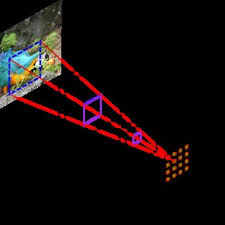

In [6]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        # Initial convolutional layer with stride 2
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels * 2,  # Number of input channels is doubled because of concatenation
                features[0],  # Number of output channels
                kernel_size=4,  # Kernel size
                stride=2,  # Stride of 2 halves the size of the image
                padding=1,  # Padding to maintain spatial dimensions
                padding_mode="reflect",  # Reflect padding pads the input with a reflection of itself
            ),
            nn.LeakyReLU(0.2),  # Activation function
        )

        # Sequential layer with multiple convolutional and normalization layers
        layers = []
        in_channels = features[0]  # Number of input channels for the first layer
        for feature in features[1:]:
            layers.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels,  # Number of input channels
                        feature,  # Number of output channels
                        kernel_size=4,  # Kernel size
                        stride=1 if feature == features[-1] else 2,  # Stride of 1 for the last layer, otherwise 2
                        padding=1,  # Padding to maintain spatial dimensions
                        padding_mode="reflect",  # Reflect padding pads the input with a reflection of itself
                    ),
                    nn.BatchNorm2d(feature),  # Batch normalization layer
                    nn.LeakyReLU(0.2),  # Activation function
                )
            )
            in_channels = feature  # Update the number of input channels for the next layer

        # Final convolutional layer with single channel output
        layers.append(
            nn.Conv2d(
                in_channels,  # Number of input channels
                1,  # Number of output channels
                kernel_size=4,  # Kernel size
                stride=1,  # Stride of 1 maintains the size of the image
                padding=2,  # Padding to maintain spatial dimensions
                padding_mode="reflect",  # Reflect padding pads the input with a reflection of itself
            ),
        )

        # Stack the layers into a single model
        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        # Concatenate the two input images along the channel dimension
        x = torch.cat([x, y], dim=1)
        # Pass the concatenated image through the initial convolutional layer
        x = self.initial(x)
        # Pass the output through the rest of the layers
        x = self.model(x)
        # Return the output
        return x

In [7]:
def test_discriminator():
        # -----------------------------------------------------
        #  test discriminator : output should be (B,1,32,32)
        # -----------------------------------------------------
        ############### Complete this part ############### (3 points)
        x = torch.randn((1, 3, 256, 256))
        y = torch.randn((1, 3, 256, 256))
        model = Discriminator(in_channels=3)
        preds = model(x, y)
        print(preds.shape)


test_discriminator()

torch.Size([1, 1, 32, 32])


#5-define hyperparameters and useful functions

In [8]:
DATA_SET_TRAIN = "/content/maps/train"
DATA_SET_VAL = "/content/maps/val"
BATCH_SIZE = 1
LR = 0.0002
B1 = 0.5
B2 = 0.999
IMG_HEIGHT = 256
IMG_WIDTH =  256
EPOCH = 100

# This function initializes the weights of a neural network model in PyTorch. It takes a single argument, m, which is a module (e.g., a layer) in the model.
# This function is often used as a weights_init function when defining a PyTorch model, which can then be applied to the model using the apply method:
# model = MyModel()
# model.apply(weights_init_normal)


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

#6-training(50 p)

In [10]:
from torchvision.utils import save_image

# Check if GPU is available and store the result in 'cuda'
cuda = torch.cuda.is_available()

# GAN loss function using mean squared error
criterion_GAN = torch.nn.MSELoss()

# Pixel-wise loss function using mean absolute error
criterion_pixelwise = torch.nn.L1Loss()

# Weight for pixel-wise loss in total loss
lambda_pixel = 100

# Initialize generator and discriminator networks
generator = Generator()
discriminator = Discriminator()

# Initialize network weights using normal distribution
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# If GPU is available, move the networks and loss functions to the GPU
if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    criterion_GAN.cuda()
    criterion_pixelwise.cuda()

# Adam optimizers for generator and discriminator
optimizer_G = torch.optim.Adam(generator.parameters(), lr=LR, betas=(B1, B2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=(B1, B2))

# DataLoader for training data
dataloader = DataLoader(Maps_Dataset(DATA_SET_TRAIN), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# DataLoader for validation data
val_dataloader = DataLoader(Maps_Dataset(DATA_SET_VAL), batch_size=4, shuffle=True, num_workers=2)

# Tensor type for GPU or CPU
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# Training loop
for epoch in range(EPOCH):
    G_loss = 0
    D_loss = 0
    for i, batch in enumerate(dataloader):

        
        # Get model inputs
        IMG_REAL = Variable(batch["IMAGE"].type(Tensor))
        MAP_REAL = Variable(batch["MAP"].type(Tensor))

        # Adversarial ground truths
        patcc_gan_output = (1, 32,32)
        REAL = Variable(Tensor(np.ones((IMG_REAL.size(0), *patcc_gan_output))), requires_grad=False)
        FAKE = Variable(Tensor(np.zeros((IMG_REAL.size(0), *patcc_gan_output))), requires_grad=False)

        # -------------------------------------------------------
        #  Train Generator
        # -------------------------------------------------------
        ############### Complete this part ############### (15 points)
        optimizer_G.zero_grad()
        map_fake = generator(IMG_REAL)
        logits_fake = discriminator(map_fake, IMG_REAL)
        adv_loss = criterion_GAN(logits_fake, REAL)
        recon_loss = criterion_pixelwise(map_fake, MAP_REAL)
        gen_loss = adv_loss + (recon_loss * lambda_pixel)
        G_loss += gen_loss
        gen_loss.backward()
        optimizer_G.step()


        # ------------------------------------------------------
        #  Train Discriminator
        # ------------------------------------------------------
        ############### Complete this part ############### (15 points)
        optimizer_D.zero_grad()
        map_fake = generator(IMG_REAL)
        logits_fake = discriminator(map_fake, IMG_REAL)
        logits_real = discriminator(MAP_REAL, IMG_REAL)
        fake_loss=criterion_GAN(logits_fake, FAKE)
        real_loss=criterion_GAN(logits_real, REAL)
        disc_loss = (fake_loss+real_loss)/2
        D_loss += disc_loss
        disc_loss.backward()
        optimizer_D.step()



        Iteration = epoch * len(dataloader) + i

        # -----------------------------------------------------
        #  every 500 iterations: print logs you need 
        # -----------------------------------------------------
        ############### Complete this part ############### (10 points)
        if Iteration%500==499:
          print(f'epoch {epoch}: loss generator {G_loss/(i+1)} loss descriminator {D_loss/(i+1)}')
        #------------------------------------------------------
        # every 500 iterations: give one batch of val data(4 images) to generator and save results in .png or .jpg
        #------------------------------------------------------
        ############### Complete this part ############### (10 points)
        if Iteration%500==499:
          batch=next(iter(val_dataloader))
          IMG_REAL = Variable(batch["IMAGE"].type(Tensor))
          MAP_REAL = Variable(batch["MAP"].type(Tensor))
         
          MAP_REALS=torch.cat((MAP_REAL[0].detach(),MAP_REAL[1].detach(),MAP_REAL[2].detach(),MAP_REAL[3].detach()),1)
          MAP_GENS=torch.cat((generator(IMG_REAL)[0].detach(),generator(IMG_REAL)[1].detach(),generator(IMG_REAL)[2].detach(),generator(IMG_REAL)[3].detach()),1)
          
          print(f'Map-image of iteration {Iteration} saved! ')
          save_image(torch.cat((MAP_REALS,MAP_GENS),2), f'Gen-Images/{Iteration}.png')



epoch 0: loss generator 14.617841720581055 loss descriminator 0.43924617767333984
Map-image of iteration 499 saved! 
epoch 0: loss generator 12.917915344238281 loss descriminator 0.36323559284210205
Map-image of iteration 999 saved! 
epoch 1: loss generator 10.717933654785156 loss descriminator 0.2332426905632019
Map-image of iteration 1499 saved! 
epoch 1: loss generator 10.549761772155762 loss descriminator 0.2295525074005127
Map-image of iteration 1999 saved! 
epoch 2: loss generator 10.364697456359863 loss descriminator 0.19890768826007843
Map-image of iteration 2499 saved! 
epoch 2: loss generator 10.332144737243652 loss descriminator 0.1846664696931839
Map-image of iteration 2999 saved! 
epoch 3: loss generator 9.896904945373535 loss descriminator 0.15485964715480804
Map-image of iteration 3499 saved! 
epoch 3: loss generator 9.943799018859863 loss descriminator 0.16163484752178192
Map-image of iteration 3999 saved! 
epoch 4: loss generator 9.807658195495605 loss descriminator 0.

In [ ]:
# !zip -r /content/Gen-Images100.zip /content/Gen-Images

# Display (10 P)


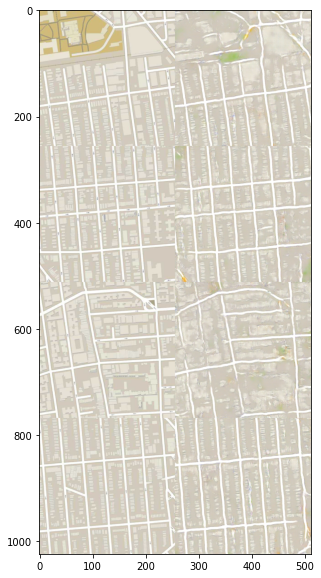

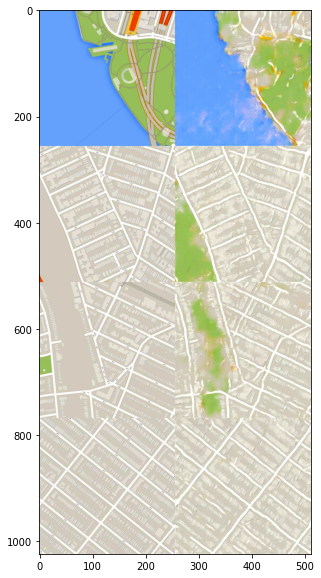

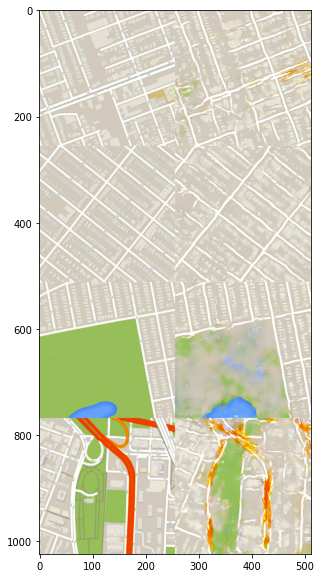

In [37]:
#------------------------------------------------------
# display 12 (3 batches of the best results you saved in the previous step)
#------------------------------------------------------
############### Complete this part ############### (10 points)
import matplotlib.pyplot as plt
from torchvision.io import read_image

img1 = read_image('Gen-Images/106999.png')
plt.figure(figsize=(20,10))
plt.imshow(img1.permute(1,2,0))

img2 = read_image('Gen-Images/101999.png')
plt.figure(figsize=(20,10))
plt.imshow(img2.permute(1,2,0))

img3 = read_image('Gen-Images/108499.png')
plt.figure(figsize=(20,10))
plt.imshow(img3.permute(1,2,0))